# Modeling

First thing, I want to see what the simplest, baseline model for my data is. To do this, I will just find whatever I have that correlates the most with PRICE and then create a model with it.

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import functions
import numpy as np
from sklearn.preprocessing import StandardScaler

In [149]:
# Import data
kc = pd.read_csv('../../Data/matthew_clean_data.csv', index_col=0)

In [150]:
# Create Correlation matrix
kc_matrix = kc.corr()
kc_matrix['price']

id             -0.016772
price           1.000000
grade           0.667951
yr_built        0.053953
yr_renovated    0.125499
floors_1.5      0.015896
floors_2.0      0.232696
floors_2.5      0.122845
floors_3.0      0.020036
floors_3.5      0.018132
Name: price, dtype: float64

## Simple Model: Price ~ Grade

In [151]:
# Grade seems to have the highest correlation here. Let's start there

#Train/Test Split
X = kc.drop(columns=['price', 'date', 'yr_renovated'])
y = kc['price']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                 1.180e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:12:40   Log-Likelihood:            -2.0155e+05
No. Observations:               14469   AIC:                         4.031e+05
Df Residuals:                   14467   BIC:                         4.031e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.332e+05   9243.421    -46.862      0.000   -4.51e+05   -4.15e+05
grade       2.086e+05   1920.927    108.612      0.000    2.05e+05    2.12e+05
==============================================================================
Omnibus:                    13244.280   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1345103.443
Skew:                           4.039   Prob(JB):                         0.00
Kurtosis:                      49.539   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
# For comparing the models, let's also use our evaluate() function to get R2, RMSE, MAE
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4492
Test R2: 0.4402
****
Train RMSE: $271,330.98
Test RMSE: $277,542.69
****
Train MAE: $174,293.34
Test MAE: $176,208.96


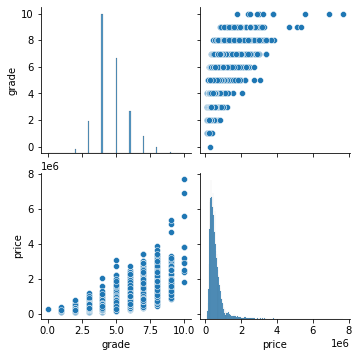

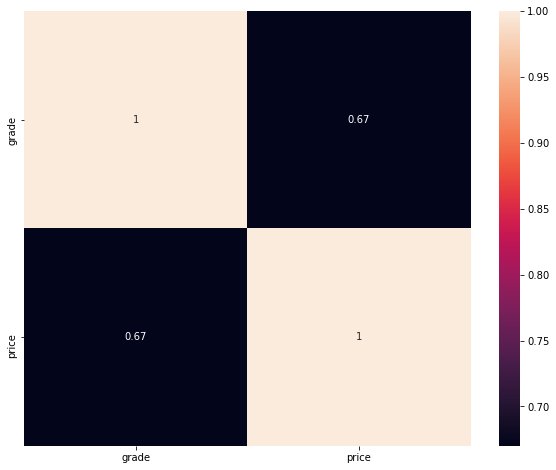

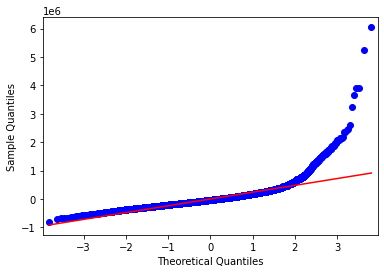

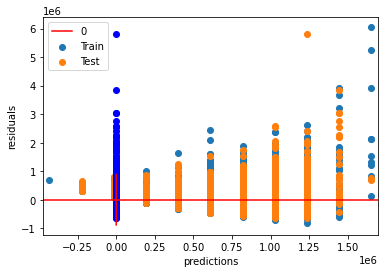

In [153]:
# Let's also check the assumptions of linearity.
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
Looking at the results two things stick out to me:
- The RMSE and MAE have a difference of about $98,000 dollars.

- This model violates the "residual normality" assumption of linear regression. The Jarque-Bera score of 1,991,063 also reinforces this.
- It may also have some heteroscedasticity as well, violating another assumption.

This is definitely a good start, but I think it would benefit any model moving forward to remove the extreme outliers.

## (Price ~ Grade) with removed outliers

In [154]:
# Remove the 5% most expensive houses
kc_trim = kc[kc['price'] < kc['price'].quantile(0.95)]

# Redo the Train/Test Split and exclude outliers
X = kc_trim.drop(columns=['price', 'date', 'yr_renovated'])
y = kc_trim['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     9386.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:12:51   Log-Likelihood:            -1.8445e+05
No. Observations:               13743   AIC:                         3.689e+05
Df Residuals:                   13741   BIC:                         3.689e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.09e+05   6213.628    -17.541      0.000   -1.21e+05   -9.68e+04
grade       1.296e+05   1337.854     96.880      0.000    1.27e+05    1.32e+05
==============================================================================
Omnibus:                      949.404   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1170.176
Skew:                           0.669   Prob(JB):                    7.93e-255
Kurtosis:                       3.505   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4058
Test R2: 0.4012
****
Train RMSE: $163,207.39
Test RMSE: $162,596.98
****
Train MAE: $128,921.94
Test MAE: $128,141.70


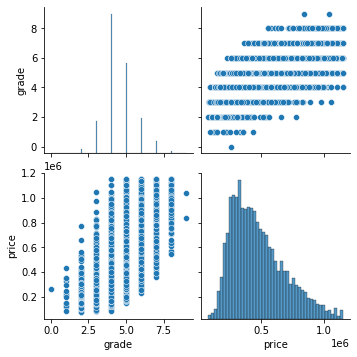

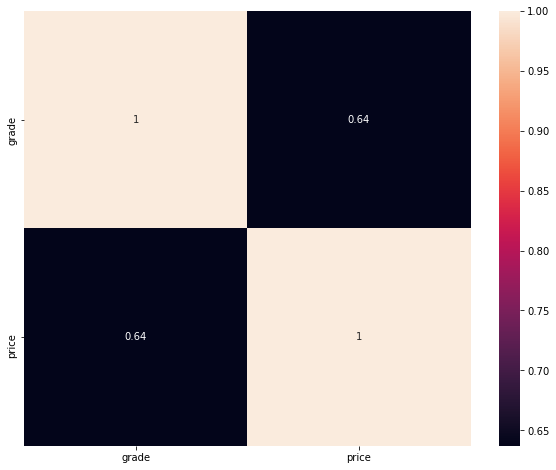

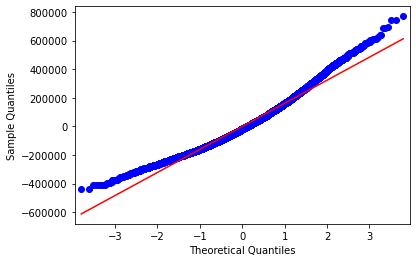

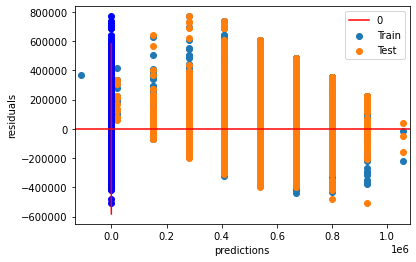

In [156]:
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
This test is interesting:
- The R-Squared went down by about 0.082

but:
- our RMSE went down by about $111,000
- our MSE went down by abour $47,000
- The model still violates the “residual normality” assumption of linear regression. However The Jarque-Bera is now 1270, *much* lower then the previous score of 1,991,063!
- The heteroscedasticity still seems to be present

Overall, I'd say this is an improvement! I think it would be smart to remove outliers like I've done here for any models moving forward. I think it would also be possible to tune the quantile I use to further improve accuracy. For now, I think it'd be better to move on.

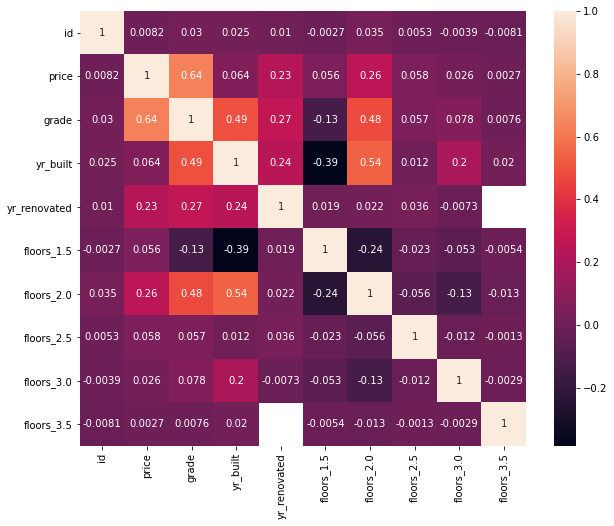

In [157]:
# Before moving forward, I'd like to check the correlation matrix again with removed outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(kc_trim.corr(), annot=True, )
plt.show()

## Renovated
Interestingly, there has been a general uptick in correlations. I think it would be a good idea to investigate the "yr_renovated" column. But let's instead create a column that indicated if a house has been renovated at all, and see if there's any correlation there.

In [158]:
kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)

<ipython-input-158-f37bbce968aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)


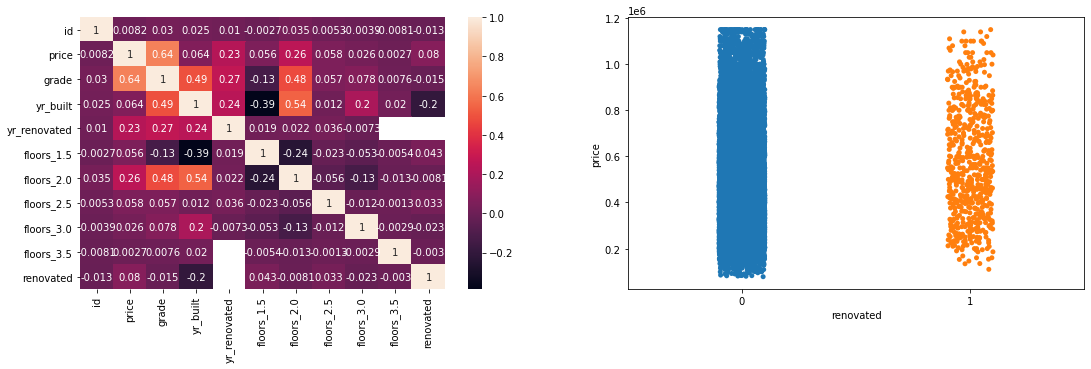

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(kc_trim.corr(), annot=True, ax=ax1)
sns.stripplot(data=kc_trim, x='renovated', y='price', ax=ax2)
plt.show()

an interesting feature, but doesn't look anymore useful then 'yr_renovated'

# Price ~ grade + floors_2.0
I'd like to see if adding 'floors_2.0' to our previous model will result in an improvement.

In [160]:
# No need to re-split since this is a new model
model = sm.OLS(y_train, sm.add_constant(X_train[['grade', 'floors_2.0']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     4754.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:13:22   Log-Likelihood:            -1.8442e+05
No. Observations:               13743   AIC:                         3.688e+05
Df Residuals:                   13740   BIC:                         3.689e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.273e+05   6558.086    -19.406      0.000    -1.4e+05   -1.14e+05
grade       1.359e+05   1525.937     89.071      0.000    1.33e+05    1.39e+05
floors_2.0 -2.809e+04   3297.199     -8.519      0.000   -3.46e+04   -2.16e+04
==============================================================================
Omnibus:                      939.161   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1159.174
Skew:                           0.661   Prob(JB):                    1.94e-252
Kurtosis:                       3.527   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
train_preds = model.predict(sm.add_constant(X_train[['grade', 'floors_2.0']]))
test_preds = model.predict(sm.add_constant(X_test[['grade', 'floors_2.0']]))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4090
Test R2: 0.4039
****
Train RMSE: $162,778.06
Test RMSE: $162,235.35
****
Train MAE: $128,524.80
Test MAE: $127,614.65


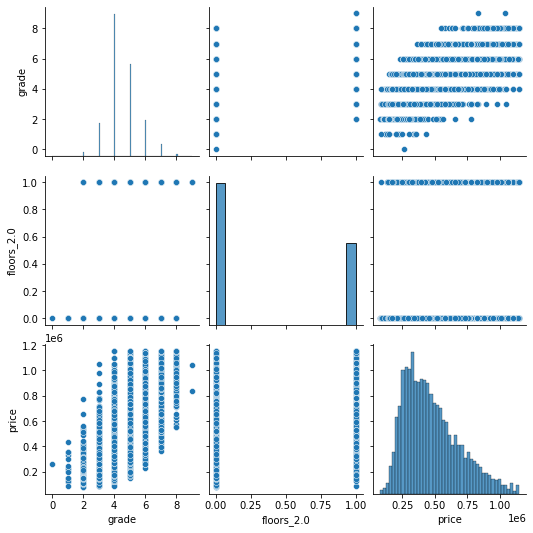

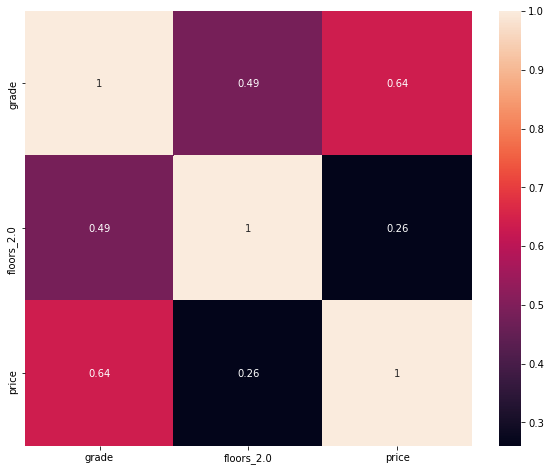

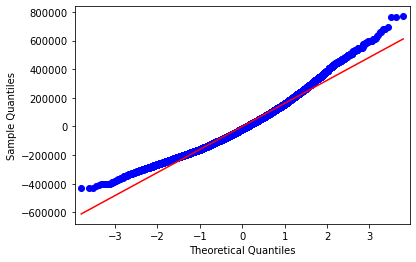

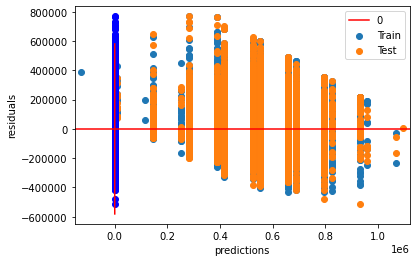

In [162]:
functions.check_assumptions(X_train[['grade', 'floors_2.0']], y_train, train_preds, test_preds, y_test)

## Conclusion
Overall, a **very small** increase in performance across all categories, but it still containes the same issues as the previous model (assumptions of linearity). This is an improvement for sure, however, I think it would be more effective to move on to combining what I have here with some of my partners' models. I think that any more experimintation here would only result in minor increase to performance, as seen in this last model.

## Cleaned Columns ~ Price
I want to get a quick overview of all of our clean columns so that I can better help my group put the final model together

In [203]:
# Import Steve and Tony's cleaned data
s = pd.read_csv('../../Data/my_filtered_dataframe_id.csv', index_col=0)
t = pd.read_csv('../../Data/cleanhousedata_id.csv', index_col=0)

,id,price,date,yr_renovated,yr_built,condition,grade,view,waterfront,zipcode,lat,long,cat_waterfront,cat_view,cat_condition,cat_grade,cat_zipcode
0,7129300520,221900.0,10/13/2014,NaN,1955,3,4,NONE,NaN,98178,47.5112,-122.257,NaN,NONE,Average,7 Average,98178
1,6414100192,538000.0,12/9/2014,1991.0,1951,3,4,NONE,NO,98125,47.7210,-122.319,NO,NONE,Average,7 Average,98125
2,5631500400,180000.0,2/25/2015,NaN,1933,3,3,NONE,NO,98028,47.7379,-122.233,NO,NONE,Average,6 Low Average,98028
3,2487200875,604000.0,12/9/2014,NaN,1965,5,4,NONE,NO,98136,47.5208,-122.393,NO,NONE,Very Good,7 Average,98136
4,1954400510,510000.0,2/18/2015,NaN,1987,3,5,NONE,NO,98074,47.6168,-122.045,NO,NONE,Average,8 Good,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,5/21/2014,NaN,2009,3,5,NONE,NO,98103,47.6993,-122.346,NO,NONE,Average,8 Good,98103
21593,6600060120,400000.0,2/23/2015,NaN,2014,3,5,NONE,NO,98146,47.5107,-122.362,NO,NONE,Average,8 Good,98146
21594,1523300141,402101.0,6/23/2014,NaN,2009,3,4,NONE,NO,98144,47.5944,-122.299,NO,NONE,Average,7 Average,98144
21595,291310100,400000.0,1/16/2015,NaN,2004,3,5,NONE,NaN,98027,47.5345,-122.069,NaN,NONE,Average,8 Good,98027


In [210]:
# Setting index to ID column for merging
t.set_index('id')
kc.set_index('id')
s.set_index('id')

In [211]:
# Merging all cleaned data
kct = kc_trim.merge(t, on='id')
all_clean = kct.merge(s, on='id')


In [212]:
# For this model, I want to just put in as many variables as I can and see what happens. First I remove any category columns or columns with NAN in them.
all_clean.drop(axis=1, labels=['view_y', 'price_y', 'grade_y', 'yr_built_y', 'date_y', 'yr_renovated_y'], inplace=True)

In [213]:
all_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18183 non-null  int64  
 1   price_x         18183 non-null  float64
 2   grade_x         18183 non-null  int64  
 3   date_x          18183 non-null  object 
 4   yr_built_x      18183 non-null  int64  
 5   yr_renovated_x  452 non-null    float64
 6   floors_1.5      18183 non-null  int64  
 7   floors_2.0      18183 non-null  int64  
 8   floors_2.5      18183 non-null  int64  
 9   floors_3.0      18183 non-null  int64  
 10  floors_3.5      18183 non-null  int64  
 11  renovated       18183 non-null  int64  
 12  view_x          18183 non-null  object 
 13  sqft_living     18183 non-null  int64  
 14  sqft_lot        18183 non-null  int64  
 15  bedrooms        18183 non-null  int64  
 16  bathrooms       18183 non-null  int64  
 17  price           18183 non-null 

In [243]:

ss  = StandardScaler()

# Dropping copies of columns and price
X = all_clean.drop(columns=['price', 'date_x', 'yr_renovated_x', 'waterfront', 'cat_waterfront', 'view_x', 'cat_view', 'cat_condition', 'cat_grade', 'price_x'])

# Column names for future use
colms = X.columns
y = all_clean['price']
# Scale all features
X = ss.fit_transform(X)
# Placing back into a dataframe
X = pd.DataFrame(X, columns=colms)

# TTS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)



In [246]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
# Getting a summary and formatting it to not be in Scientific notation
model.summary2(float_format='%.4f')

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:                 OLS               Adj. R-squared:      0.601      
Dependent Variable:    price             AIC:                 312294.7214
Date:                  2021-10-06 21:17  BIC:                 312428.0603
No. Observations:      12182             Log-Likelihood:      -1.5613e+05
Df Model:              17                F-statistic:         1080.      
Df Residuals:          12164             Prob (F-statistic):  0.00       
R-squared:             0.601             Scale:               7.9497e+09 
-------------------------------------------------------------------------
               Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-------------------------------------------------------------------------
const       405247.0456  807.9915 501.5487 0.0000 403663.2537 406830.8374
id            4233.9001  815.2484   5.1934 0.0000   2635.8836   5831.9167
grade_x      52481.0235 1180.0918  44.4720 0.0000  50167.8560  54794.1910
yr_built_x  -35324.4829 1393.3094 -25.3529 0.0000 -38055.5909 -32593.3748
floors_1.5    5840.2572  884.0875   6.6060 0.0000   4107.3052   7573.2092
floors_2.0   10735.3964 1120.4507   9.5813 0.0000   8539.1348  12931.6580
floors_2.5    3748.3973  835.4654   4.4866 0.0000   2110.7523   5386.0423
floors_3.0    6767.4978  929.7201   7.2791 0.0000   4945.0986   8589.8971
floors_3.5    1439.0859  726.3272   1.9813 0.0476     15.3690   2862.8027
renovated      213.7446  827.5017   0.2583 0.7962  -1408.2904   1835.7796
sqft_living  42990.0298 1432.2902  30.0149 0.0000  40182.5132  45797.5464
sqft_lot     10567.7864  923.2886  11.4458 0.0000   8757.9939  12377.5789
bedrooms     -9493.1986 1068.5902  -8.8839 0.0000 -11587.8054  -7398.5918
bathrooms    15123.8602 1373.9647  11.0075 0.0000  12430.6708  17817.0496
condition    11246.9167  873.4187  12.8769 0.0000   9534.8772  12958.9562
zipcode      -1948.7860  511.7820  -3.8078 0.0001  -2951.9601   -945.6119
lat          67165.0238  879.4520  76.3714 0.0000  65441.1579  68888.8897
long          3462.8814 1049.5933   3.2993 0.0010   1405.5115   5520.2512
cat_zipcode  -1948.7860  511.7820  -3.8078 0.0001  -2951.9601   -945.6119
-------------------------------------------------------------------------
Omnibus:            267.095      Durbin-Watson:         2.009            
Prob(Omnibus):      0.000        Jarque-Bera (JB):      331.083          
Skew:               0.295        Prob(JB):              0.000            
Kurtosis:           3.551        Condition No.:         23066200742250308
=========================================================================
* The condition number is large (2e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

In [251]:
# Get the Coefficients and sort them for direct comparison
model.params.sort_values(ascending=False)


const          405247.045568
lat             67165.023804
grade_x         52481.023526
sqft_living     42990.029820
bathrooms       15123.860192
condition       11246.916718
floors_2.0      10735.396416
sqft_lot        10567.786354
floors_3.0       6767.497807
floors_1.5       5840.257226
id               4233.900147
floors_2.5       3748.397320
long             3462.881392
floors_3.5       1439.085856
renovated         213.744647
cat_zipcode     -1948.786017
zipcode         -1948.786017
bedrooms        -9493.198641
yr_built_x     -35324.482857
dtype: float64

In [252]:
# Evaluating this "draft" of our final model
train_preds = model.predict(sm.add_constant(X_train))
test_preds = model.predict(sm.add_constant(X_test))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.6014
Test R2: 0.6050
****
Train RMSE: $89,095.09
Test RMSE: $89,495.77
****
Train MAE: $69,697.98
Test MAE: $70,339.69


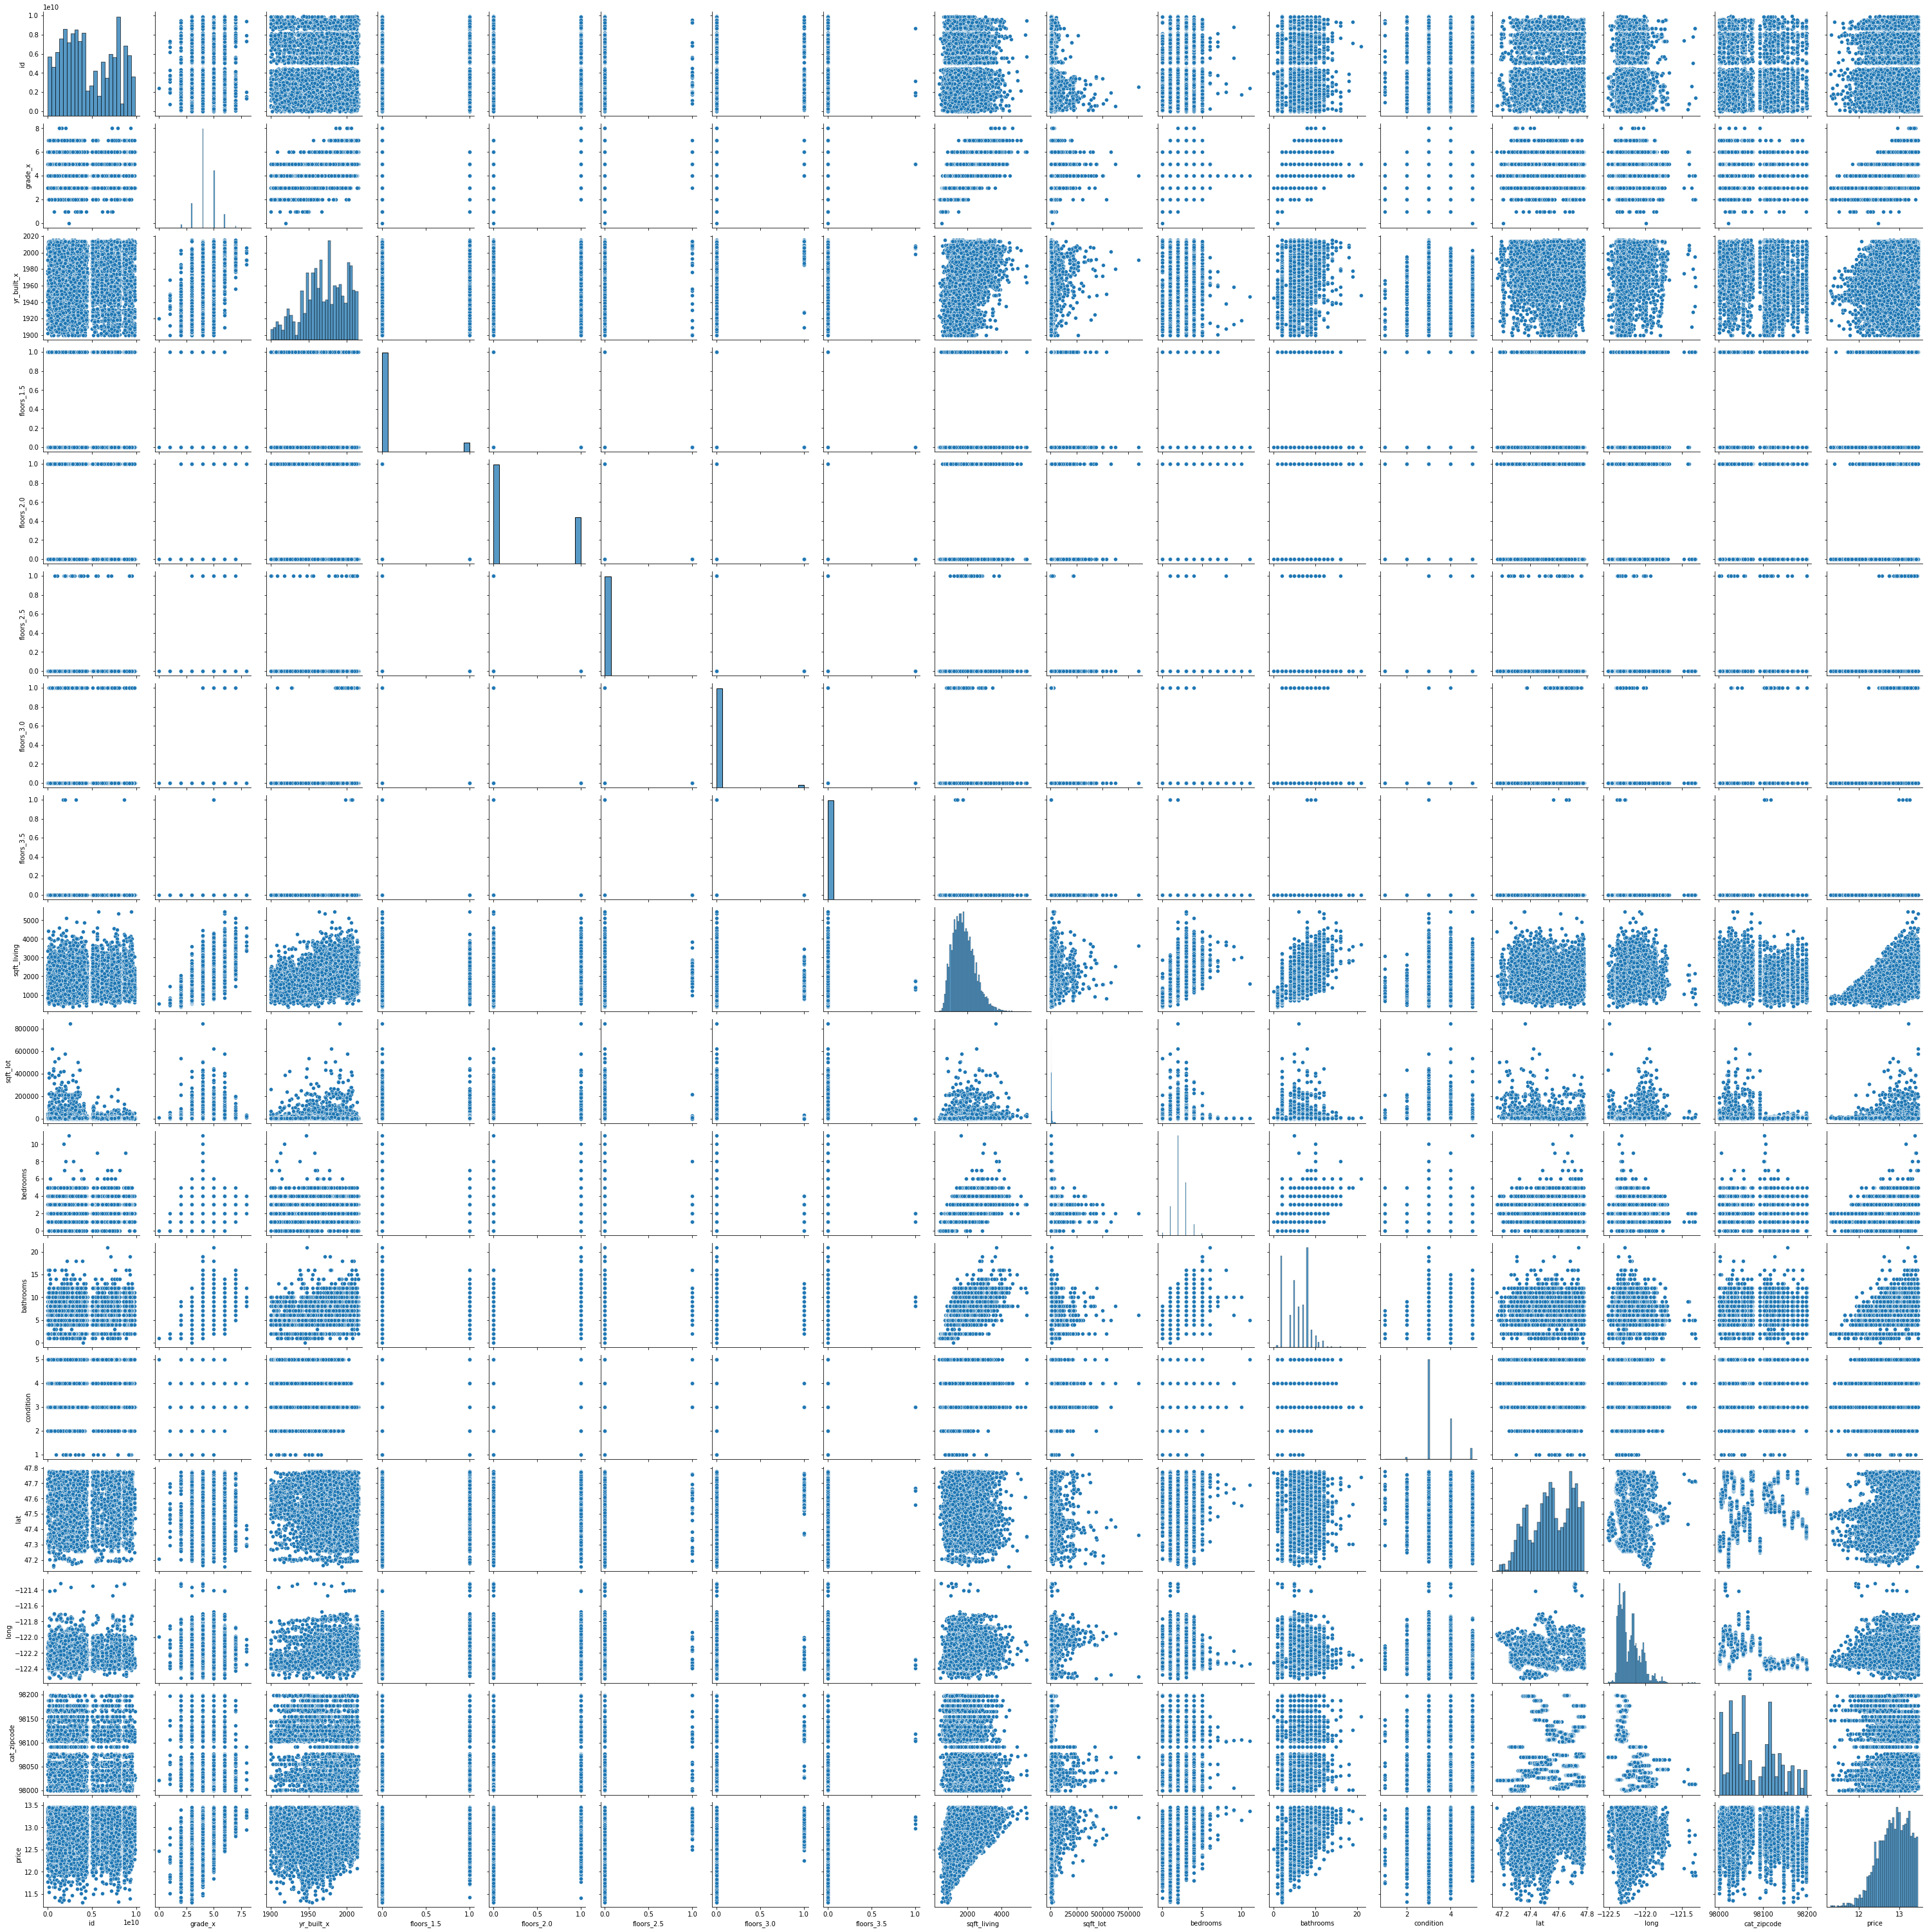

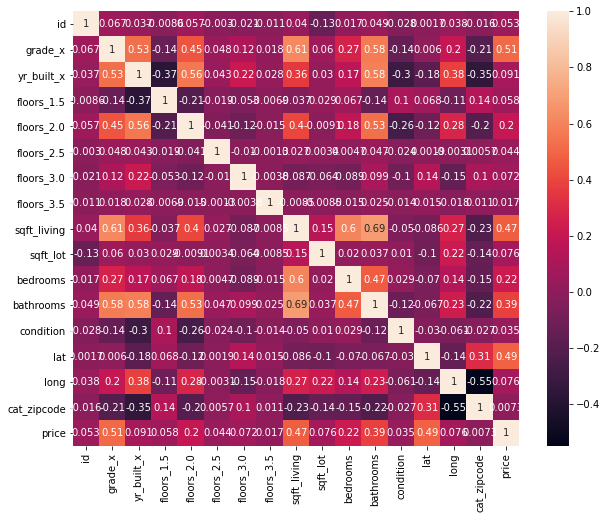

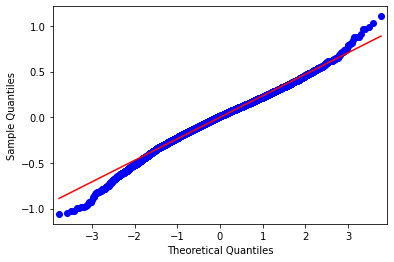

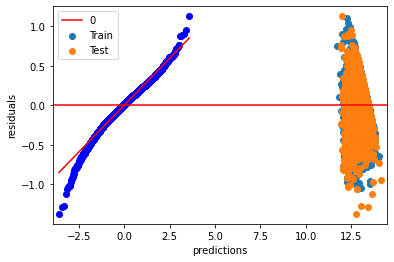

In [191]:
# Also checking assumptions of "draft" final model
functions.check_assumptions(X_train, y_train, train_preds, test_preds, y_test)

## Conclusion
I just wanted to throw all of our cleaned data together to see what happened. This model is decent, but extremely flawed
- There are some huge multicolinearity issues that will need to be addressed.
- Residual normality is okay, but still not in a good spot
- I'm not even sure how to interpret